# TestProgram: van der Pol 振動子



In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import numpy as np
import sdeint
from scipy import integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import Estimator_module
import Adjoint_module




from matplotlib.font_manager import FontProperties
fp1 = FontProperties(fname=r'/Users/arataka/Library/Fonts/ipaexg.ttf', size=10)
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 10 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 10 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 10 # 軸だけ変更されます
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.facecolor']= 'white'

# **config**

In [2]:
# 系の設定
param_a1, param_a2 = 0.3, 0.7
param_K1, param_K2 = 0.01, 0.01
param_sigma = 0.00


# 推定に使う時系列の長さ  (\Delta \phi<= 2*pi*cycle)
cycle=100

# hyper parameter
# 推定に使うハイパーパラメータを指定
alpha_0, beta_0 = 0.1, 0.1
## lambda_0が大きいほど関数の分散は明確に小さくなる. 基本的に0以上を設定
log10_lambda_0_min, log10_lambda_0_max = 1, 1
## 各PRCの次数
M_min, M_max = 0, 10

## SDE time step
dt = 0.005
t_end = 41000.0

## クラス: van der Pol SDE
    入力がある van der Pol の数値計算用クラス.

In [3]:
class VdP():
    def __init__(self):
        import sdeint
        self.sigma = 0.01
        self.a1 = 0.3
        self.a2 = 0.7
        self.K1 = 0.01
        self.K2 = 0.01
        self.B = np.diag([0.0, self.sigma, 0.0, self.sigma])
        # seed
        self.seed = 1
    
    def G(self, x, t):
        """ noise (Input) """
        return  self.B 

    def F(self, x, t):
        u1, v1, u2, v2 = x 
        f_u1 = v1
        f_v1 = self.a1*(1.0-u1**2)*v1 - u1 + self.K1*(v2-v1)
        f_u2 = v2
        f_v2 = self.a2*(1.0-u2**2)*v2 - u2 + self.K2*((v1**2)*u2-(v2**2)*u1)
        return np.array([f_u1, f_v1, f_u2, f_v2])
    
    def solve_SDE(self, x0, tspan):
        np.random.seed(self.seed)
        return sdeint.itoint(self.F, self.G, x0, tspan)
    


## クラス:
周期軌道とadjoint法のためのクラス.  
ベクトル場, ヤコビアン, 周期を求める それぞれのメソッド

In [4]:
rtol=1e-6; atol=1e-9
class VdP_for_adjoint():
    def __init__(self):
        # 極大計算, 周期計算etc. の際に用いるconfig設定
        self.a = 0.7
        self.init_dt = 0.01 # 初期の刻み幅
        self.transient = 20000 # 収束させる時間
        self.grid_for_approximation = 2**3+1 # 極大近似計算において使用するgrid点の数
        self.num_bisection = 16 # 周期計算で使用する二分法回数

    def F(self, t, x):
        u, v = x 
        f_u = v 
        f_v = self.a*(1.0-u**2)*v - u
        return np.array([f_u, f_v])

    def J(self, x):
        """ヤコビアン"""
        u, v = x
        return np.array([[0., 1.],
                         [-1.0-2.0*self.a*u*v, self.a*(1.0-u**2)]])

    def solve_ODE(self, tspan, x0):
        """ 軌道計算用 """
        sol = integrate.solve_ivp(self.F, tspan[[0, -1]], x0, t_eval=tspan)
        return sol
    

    def phase_zero_marker_and_period(self, init_x0=np.array([0.1, 0.1]), Poincare_v=0.0):
        """ ポアンカレ上の点を求め, 周期も求める."""
        def function(x0):
            """ x0計算して断面上の点とそれまでの時刻をだすルーチン"""
            # 時系列を一定時間計算する. (1周期を含むと仮定)
            dt = self.init_dt
            tspan = np.arange(0.0, 1000.0, dt)
            sol = integrate.solve_ivp(self.F, tspan[[0, -1]], x0, t_eval=tspan, 
                                        rtol=rtol, atol=atol)
            v = sol.y[1,:] # vのみの軌道
            X = sol.y.T # 全変数の軌道
            # 数値計算中でvがPoincare_vを負から正にまたぐ直前の状態点をとる.)
            arg = ((v[:-1] < Poincare_v) & (Poincare_v < v[1:]))
            v0, x0, t = v[:-1][arg][0], X[:-1][arg][0], tspan[:-1][arg][0]
            # 先程とった点から刻み幅を半分にして2step先まで計算し, 二分法探索によりポアンカレ断面の交点を探す. (交点はこの範囲に存在する.)
            for _ in range(self.num_bisection):
                dt *= 0.5
                tspan = np.array([0.0, dt, 2.0*dt])
                sol = integrate.solve_ivp(self.F, tspan[[0, -1]], x0, t_eval=tspan, 
                                            rtol=rtol, atol=atol)
                v = sol.y[1,:] # Vのみの軌道
                X = sol.y.T # 全変数の軌道
                # 真ん中の点が断面を超えている場合→進まない
                if (v[0] <= Poincare_v) & (v[1] > Poincare_v) & (v[2] >= Poincare_v):
                    v0, x0 = v[0], X[0] # ポアンカレ断面手前の点
                    v1, x1 = v[1], X[1] # ポアンカレ断面直後の点
                # 真ん中の点が断面を超えていない場合→dtだけ先に進む
                elif (v[0] <= Poincare_v) & (v[1] < Poincare_v) & (v[2] >= Poincare_v): 
                    v0, x0 = v[1], X[1] # ポアンカレ断面手前の点
                    v1, x1 = v[2], X[2] # ポアンカレ断面直後の点
                    t += dt
            
            # 最後に内分点を取り、断面上の点を取る, またその時刻も返す
            a0 = np.abs(v1 - Poincare_v) / (v1 - v0)
            a1 = np.abs(v0 - Poincare_v) / (v1 - v0)
            x0 = (a0*x0+a1*x1)/(a0+a1); x0[1] = Poincare_v
            t += (a1*dt)/(a0+a1)
            period = t
            return x0, period
            
        # 収束するまで計算
        dt = self.init_dt
        x0, tspan = init_x0, np.arange(0.0, self.transient, dt)  # x0 = [u0, v0]
        sol = integrate.solve_ivp(self.F, tspan[[0, -1]], x0, t_eval=tspan,
                                    rtol=rtol, atol=atol) 
        x0 = np.array(sol.y[:, -1])
        # 断面上の点を取る
        x0, _ = function(x0)
        # 再度断面まで戻ってくるまでの時間を計算
        _, period = function(x0) 
        return x0, period

## Adjoint法:  振動子1

In [5]:
ode1 = VdP_for_adjoint()
ode1.a = param_a1

init_x0=np.array([0.1, 0.1])
x0_marker1, period1 = ode1.phase_zero_marker_and_period(init_x0, Poincare_v=0.0) # 位相ゼロ点, 周期計算

adj_solver1 = Adjoint_module.Adjoint(ode1.F, ode1.J)
adj_solver1.grid = 2**10+1 
X1, tspan1 = adj_solver1.calculate_X(x0_marker1, period1)
adjoint_Z1 = adj_solver1.calculate_Z(X1, tspan1)
adjoint_phi1 = 2.0*np.pi*(tspan1/tspan1[-1])

print("\n")
print("===========================")
print("period_1: {:.4f}".format(period1))
print("omega_1: {:.4f}".format(2.0*np.pi/period1))
print("===========================")

trajectory converged! 
<norm:4.4155e-07>
convergence of Z: 4.9921e-05
convergence of Z: 3.6222e-09
convergence of Z: 2.6296e-13
max_t|Z(t)@dX/dt(t)-omega|=3.3307e-16


period_1: 6.3184
omega_1: 0.9944


## Adjoint: 振動子2

In [6]:
ode2 = VdP_for_adjoint()
ode2.a = param_a2

init_x0=np.array([0.1, 0.1])
x0_marker2, period2 = ode2.phase_zero_marker_and_period(init_x0, Poincare_v=0.0) # 位相ゼロ点, 周期計算

adj_solver2 = Adjoint_module.Adjoint(ode2.F, ode2.J)
adj_solver2.grid = 2**10+1 
X2, tspan2 = adj_solver2.calculate_X(x0_marker2, period2)
adjoint_Z2 = adj_solver2.calculate_Z(X2, tspan2)
adjoint_phi2 = 2.0*np.pi*(tspan2/tspan2[-1])

print("\n")
print("===========================")
print("period_2: {:.4f}".format(period2))
print("omega_2: {:.4f}".format(2.0*np.pi/period2))
print("===========================")

trajectory converged! 
<norm:1.0896e-07>
convergence of Z: 3.1705e-09
convergence of Z: 2.7989e-13
max_t|Z(t)@dX/dt(t)-omega|=4.4409e-16


period_2: 6.4728
omega_2: 0.9707


## PCRプロット

Text(0.5, 1.0, 'oscillator 2')

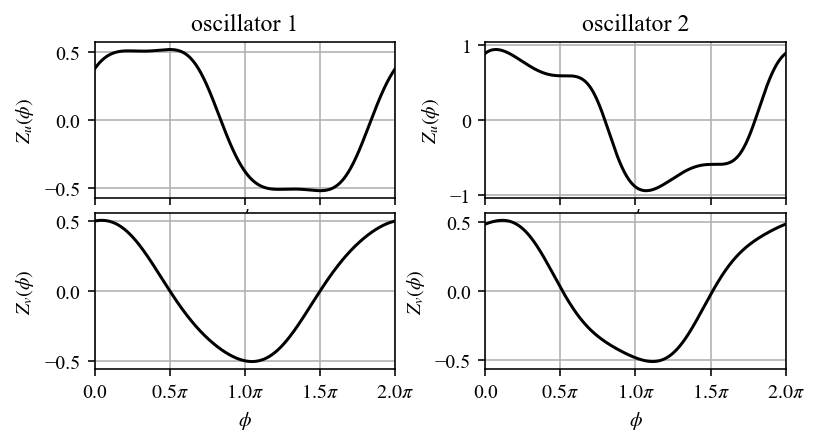

In [7]:
x1, ya, yb = adjoint_phi1, adjoint_Z1[:, 0], adjoint_Z1[:, 1]
x2, yc, yd = adjoint_phi2, adjoint_Z2[:, 0], adjoint_Z2[:, 1]

fig = plt.figure(figsize=(4.0*2, 3.0))
fig.subplots_adjust(left=0.2, right=0.8, hspace=0.1, wspace=0.3)

# 振動子1

ax = fig.add_subplot(221)
ax.plot(x1, ya, color="k", label=r"$v$")
ax.set_xlabel(r"$\phi$")
ax.set_xlim(0.0, 2.0*np.pi)
ax.set_xticks(np.linspace(0.0, 2.0*np.pi, num=5))
ax.set_ylabel(r"$Z_{u}(\phi)$")
ax.tick_params(labelbottom=False)
ax.grid()

bx = fig.add_subplot(223)
bx.plot(x1, yb, color="k", label=r"$v$")
bx.set_xlabel(r"$\phi$")
bx.set_xlim(0.0, 2.0*np.pi)
bx.set_xticks(np.linspace(0.0, 2.0*np.pi, num=5))
bx.set_ylabel(r"$Z_{v}(\phi)$")
bx.set_xticklabels(["0.0", r"$0.5\pi$", r"$1.0\pi$", r"$1.5\pi$", r"$2.0\pi$"])
bx.grid()



# 振動子2

cx = fig.add_subplot(222)
cx.plot(x2, yc, color="k", label=r"$v$")
cx.set_xlabel(r"$\phi$")
cx.set_xlim(0.0, 2.0*np.pi)
cx.set_xticks(np.linspace(0.0, 2.0*np.pi, num=5))
cx.set_ylabel(r"$Z_{u}(\phi)$")
cx.tick_params(labelbottom=False)
cx.grid()

dx = fig.add_subplot(224)
dx.plot(x2, yd, color="k", label=r"$v$")
dx.set_xlabel(r"$\phi$")
dx.set_xlim(0.0, 2.0*np.pi)
dx.set_xticks(np.linspace(0.0, 2.0*np.pi, num=5))
dx.set_ylabel(r"$Z_{v}(\phi)$")
dx.set_xticklabels(["0.0", r"$0.5\pi$", r"$1.0\pi$", r"$1.5\pi$", r"$2.0\pi$"])
dx.grid()

ax.set_title("oscillator 1")
cx.set_title("oscillator 2")


## 結合関数計算

In [8]:
def V_12(x_r, x_s):
    """ x_r:x_1, x_s:x_2
    SDEの結合と整合性があることを確認！"""
    K = param_K1 # param_K1はグローバル
    u_r, v_r = x_r
    u_s, v_s = x_s
    return np.array([0.0, K*(v_s-v_r)])

def V_21(x_r, x_s):
    """ x_r:x_2, x_s:x_1
    SDEの結合と整合性があることを確認！"""
    K = param_K2 # param_K2はグローバル
    u_r, v_r = x_r
    u_s, v_s = x_s
    return np.array([0.0, K*((v_s**2)*u_r-(v_r**2)*u_s)])
        
        
adjoint_Gamma1 = Adjoint_module.Calculater_Gamma(V_12, adjoint_phi1, X1, X2, adjoint_Z1)
adjoint_Gamma2 = Adjoint_module.Calculater_Gamma(V_21, adjoint_phi2, X2, X1, adjoint_Z2)


## 位相結合関数プロット

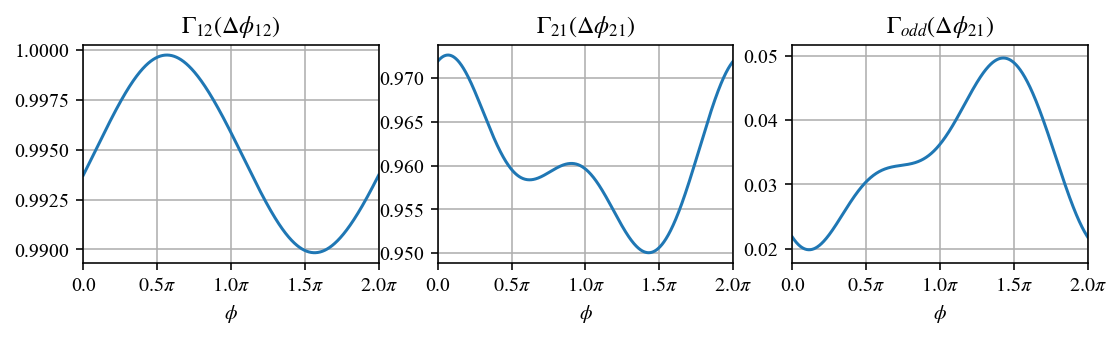

In [9]:
x = adjoint_phi1
ya = adjoint_Gamma1 + 2.0*np.pi/period1
hline_a = 2.0*np.pi/period1
yb = adjoint_Gamma2 + 2.0*np.pi/period2
hline_b = 2.0*np.pi/period2
yc = ya[::-1] - yb

fig = plt.figure(figsize=(3.0*3, 2.0))
fig.subplots_adjust()

# 振動子1
ax = fig.add_subplot(131)
ax.plot(x, ya)
# ax.hlines(hline_a, 0.0, 2.0*np.pi, color="k")
ax.set_xlabel(r"$\phi$")
ax.set_xlim(0.0, 2.0*np.pi)
ax.set_xticks(np.linspace(0.0, 2.0*np.pi, num=5))
ax.set_title(r"$\Gamma_{12}(\Delta \phi_{12})$")
ax.set_xticklabels(["0.0", r"$0.5\pi$", r"$1.0\pi$", r"$1.5\pi$", r"$2.0\pi$"])
ax.grid()

bx = fig.add_subplot(132)
bx.plot(x, yb)
# bx.hlines(hline_b, 0.0, 2.0*np.pi, color="k")
bx.set_xlabel(r"$\phi$")
bx.set_xlim(0.0, 2.0*np.pi)
bx.set_xticks(np.linspace(0.0, 2.0*np.pi, num=5))
bx.set_title(r"$\Gamma_{21}(\Delta \phi_{21})$")
bx.set_xticklabels(["0.0", r"$0.5\pi$", r"$1.0\pi$", r"$1.5\pi$", r"$2.0\pi$"])
bx.grid()

cx = fig.add_subplot(133)
cx.plot(x, yc)
cx.hlines(0.0, 0.0, 2.0*np.pi, color="k")
cx.set_xlabel(r"$\phi$")
cx.set_xlim(0.0, 2.0*np.pi)
cx.set_xticks(np.linspace(0.0, 2.0*np.pi, num=5))
cx.set_title(r"$\Gamma_{odd}(\Delta \phi_{21})$")
cx.set_xticklabels(["0.0", r"$0.5\pi$", r"$1.0\pi$", r"$1.5\pi$", r"$2.0\pi$"])
cx.set_ylim(yc.min()-0.002, yc.max()+0.002)
cx.grid()


## SDE計算

In [10]:
x0 = np.array([0.1, 0.1, 0.2, 0.2]) # x0 = [u1, v1, u2, v2]
tspan = np.arange(0.0, t_end, dt)

c = VdP()
c.a1 = param_a1;  c.a2 = param_a2
c.K1 = param_K1;  c.K2 = param_K2
c.sigma = param_sigma

result = c.solve_SDE(x0, tspan)
u1, v1 = result[:,0], result[:,1]
u2, v2 = result[:,2], result[:,3]

## transient 落とす

In [11]:
arg = (tspan > 1000) 
tspan = tspan[arg]
u1, v1 = u1[arg], v1[arg]
u2, v2  = u2[arg], v2[arg]

## プロット

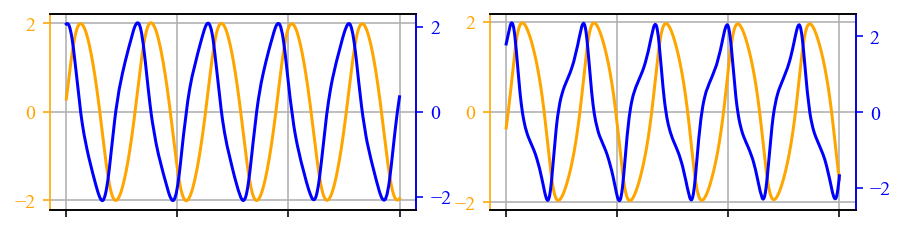

In [12]:
arg = (tspan>=1200) & (tspan<=1230)
x = tspan[arg]
ya, yb = u1[arg], v1[arg]
yd, ye = u2[arg], v2[arg]

fig = plt.figure(figsize=(4.0*2, 1.8))
fig.subplots_adjust(left=0.2)

# 振動子1
ax = fig.add_subplot(121)
bx = ax.twinx()
ax.plot(x, ya, color="orange", label=r"u")
bx.plot(x, yb, color="b", label=r"$v$")
ax.tick_params(labelbottom=False)
ax.spines["left"].set_color("orange") 
ax.tick_params(axis = 'y', colors="orange") 
bx.spines['left'].set_alpha(0) # valueに対する上の枠線を消す
bx.spines["right"].set_color("blue")  
bx.tick_params(axis = 'y', colors="blue")
ax.grid()


# 振動子2
dx = fig.add_subplot(122)
ex = dx.twinx()
dx.plot(x, yd, color="orange", label=r"u")
ex.plot(x, ye, color="b", label=r"$v$")
dx.tick_params(labelbottom=False)
dx.spines["left"].set_color("orange") 
dx.tick_params(axis = 'y', colors="orange") 
ex.spines['left'].set_alpha(0) # valueに対する上の枠線を消す
ex.spines["right"].set_color("blue")  
ex.tick_params(axis = 'y', colors="blue")
dx.grid()



## 2振動子の時系列確認, 同期してないか?

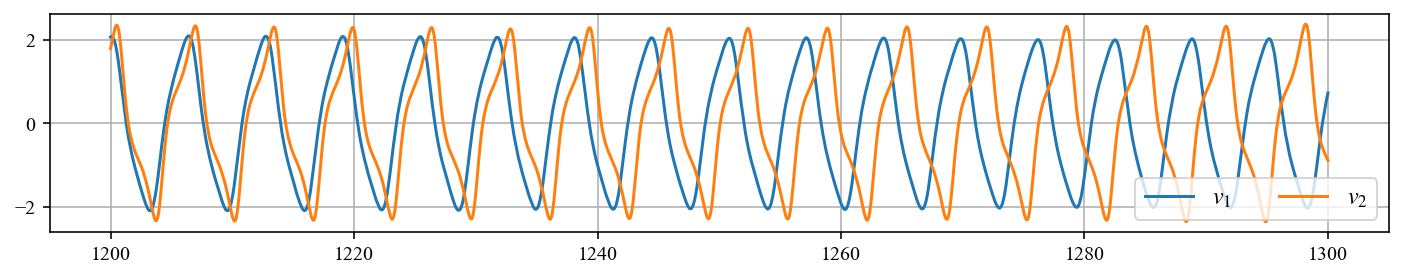

In [13]:
arg = (tspan>=1200) & (tspan<=1300)
x = tspan[arg]
y1, y2 = v1[arg], v2[arg]


fig = plt.figure(figsize=(12.0, 2.0))
ax = fig.add_subplot(111)
ax.plot(x, y1, label=r"$v_1$")
ax.plot(x, y2, label=r"$v_2$")
ax.grid()
ax.legend(ncol=2, fontsize=12, loc="lower right")

## 軌道プロット

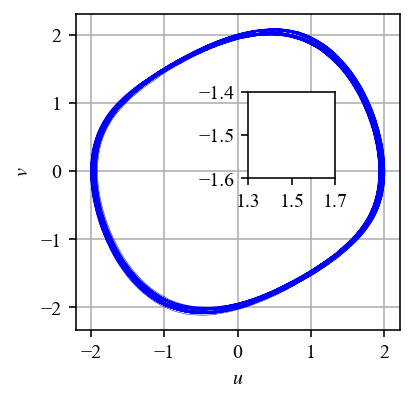

In [14]:
arg = (tspan>1000) & (tspan<=1200)
x = tspan[arg]
xa, ya = u1[arg], v1[arg]
xb, yb = u2[arg], v2[arg]


fig = plt.figure(figsize=(3.0, 3.0))
fig.subplots_adjust(left=0.15, bottom=0.15)

ax = fig.add_subplot(111)
ax.plot(xa, ya, color="b", linewidth=0.25)
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$v$")
ax.grid()

bx = fig.add_axes([0.55, 0.5, 0.2, 0.2])
bx.plot(xa, ya, color="b", linewidth=0.25)
bx.set_xlim(1.3, 1.7)
bx.set_xticks([1.3, 1.5, 1.7])
bx.set_ylim(-1.6, -1.4)
bx.set_yticks([-1.6, -1.5, -1.4])

## protophase, 位相作成
hilbert位相と Kralemannの方法による位相化

In [15]:
from scipy import signal

class Phase_transform:
    def __init__(self):
        self.M = 50

    def calculate_Sm(self, proto_phase):
        """
        ptoro_phase分布のフーリエ係数を近似的に計算, 
        詳しくは Kralemann, 2007, 2008, 2014
        """
        Sm_array = np.ones(self.M, dtype=np.complex128)
        for m in range(1, self.M + 1):
            Sm_array[int(m-1)] = np.mean(np.exp(-1j * m * proto_phase))
        return Sm_array

    def kralemann_phase(self, proto_phase, Sm_array):
        """
        kralemann_method: calculate_Smで計算したフーリエ係数Smを用いて, protophaseを位相に変換
            input:
                (ndarray) proto_phase: 1d-ndarray
            return:
                (ndarray) phase: 1d-ndarray
        """
        phase = np.copy(proto_phase)
        for m in range(1, self.M + 1):
            Sm = Sm_array[int(m-1)]
            phase += 2.0 * np.imag((Sm / m) * (np.exp(1j * m * proto_phase) - 1.0))
        return phase


In [16]:
# proto-phase (angle)  # -u+v*1j
sig1 = -u1+v1*1j; sig2 = -u2+v2*1j
proto_phase1 = np.angle(sig1 - sig1.mean())
proto_phase2 = np.angle(sig2 - sig2.mean())

# 位相を求める
pt = Phase_transform()
Sm1 = pt.calculate_Sm(proto_phase1)
phase1 = np.unwrap(pt.kralemann_phase(proto_phase1, Sm1))
Sm2 = pt.calculate_Sm(proto_phase2)
phase2 = np.unwrap(pt.kralemann_phase(proto_phase2, Sm2))
# 推定用の位相時系列
P = np.vstack([phase1, phase2]).T


## 位相時系列プロット

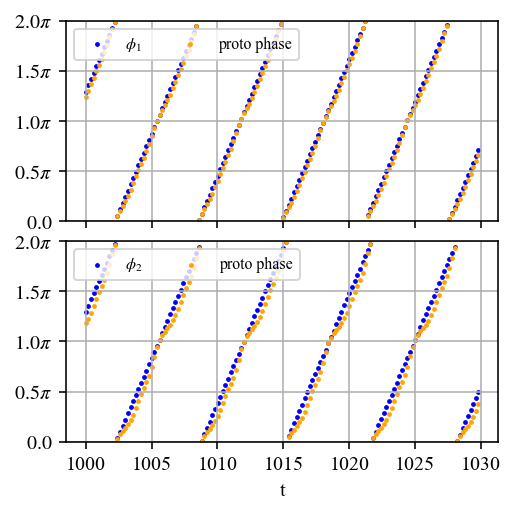

In [17]:
arg =  (1000 <= tspan) & (tspan <= 1030) 
x = tspan[arg][::40]
ya1 = np.mod(phase1[arg][::40], 2.0*np.pi)
ya2 = np.mod(proto_phase1[arg][::40], 2.0*np.pi)
yb1 = np.mod(phase2[arg][::40], 2.0*np.pi)
yb2 = np.mod(proto_phase2[arg][::40], 2.0*np.pi)

fig = plt.figure(figsize=(4.0, 4.0))
fig.subplots_adjust(left=0.15, bottom=0.15, hspace=0.1)
ax = fig.add_subplot(211)
ax.scatter(x, ya1, color="b", s=2, marker="o", label=r"$\phi_1$")
ax.scatter(x, ya2, color="orange", s=2, marker="o", label="proto phase") 
ax.set_ylim(0.0, 2.0*np.pi)
ax.set_yticks(np.linspace(0.0, 2.0*np.pi, num=5))
ax.set_yticklabels([r"$0.0$", r"$0.5\pi$", r"$1.0\pi$", r"$1.5\pi$", r"$2.0\pi$"])
ax.grid()
ax.legend(fontsize=8, ncol=2, loc="upper left")
ax.tick_params(labelbottom=False)

bx = fig.add_subplot(212)
bx.scatter(x, yb1, color="b", s=2, marker="o", label=r"$\phi_2$")
bx.scatter(x, yb2, color="orange", s=2, marker="o", label="proto phase") 
bx.set_xlabel("t")
bx.set_ylim(0.0, 2.0*np.pi)
bx.set_yticks(np.linspace(0.0, 2.0*np.pi, num=5))
bx.set_yticklabels([r"$0.0$", r"$0.5\pi$", r"$1.0\pi$", r"$1.5\pi$", r"$2.0\pi$"])
bx.grid()
bx.legend(fontsize=8, ncol=2, loc="upper left")

In [18]:
%load_ext autoreload
%autoreload 2
import Estimator_module

# 一気に学習する場合

## データ点数調整

In [19]:
phase_diff = phase1 - phase2
arg = np.abs(phase_diff-phase_diff[0]) <= 2.0*np.pi*cycle
spaned_tspan = tspan[arg]
spaned_phase1 = phase1[arg]
spaned_phase2 = phase2[arg]
spaned_phase_diff = phase_diff[arg]
spaned_u1 = u1[arg]
spaned_v1 = v1[arg]
spaned_u2 = u2[arg]
spaned_v2 = v2[arg]
spaned_P = P[arg, :] 

cycle_in_data = (spaned_phase_diff[-1]-spaned_phase_diff[0]) / (2.0*np.pi)
print("=======================")
print("cycle: {:f}".format(cycle_in_data))
print("=======================")

cycle: 99.999984


## Estimation

In [20]:


v1_mean = (P[-1,0] - P[0,0]) / (tspan[-1] - tspan[0])
v2_mean = (P[-1,1] - P[0,0]) / (tspan[-1] - tspan[0])


# receiver:1
Estimator1 = Estimator_module.Estimator(receiver=0, N=2,
                                        M_min=M_min, M_max=M_max,
                                        log10_lambda_0_min=log10_lambda_0_min, 
                                        log10_lambda_0_max=log10_lambda_0_max,  
                                        alpha_0=alpha_0, beta_0=beta_0)
# set intial condition (initial condition of omega)
Estimator1.set_init_all(v1_mean)
# update
Estimator1.update_all(spaned_P, delta_t=dt)
# model section
result_model1, _ = Estimator1.model_selection()


# receiver:2
Estimator2 = Estimator_module.Estimator(receiver=1, N=2,
                                        M_min=M_min, M_max=M_max,
                                        log10_lambda_0_min=log10_lambda_0_min, 
                                        log10_lambda_0_max=log10_lambda_0_max,  
                                        alpha_0=alpha_0, beta_0=beta_0)
# set intial condition (initial condition of omega)
Estimator2.set_init_all(v2_mean)
# update
Estimator2.update_all(spaned_P, delta_t=dt)
# model section
result_model2, _ = Estimator2.model_selection()

## データ整理

In [21]:

##### データ整理
G1m, G1s, phi  = result_model1.return_Gamma(sender=1)
O1m, O1s = result_model1.return_omega()
D1m, D1s = result_model1.return_D(delta_t=dt)
Gamma1_order = result_model1.return_Gamma_order(sender=1)

G2m, G2s, _   = result_model2.return_Gamma(sender=0)
O2m, O2s = result_model2.return_omega()
D2m, D2s = result_model2.return_D(delta_t=dt)
Gamma2_order = result_model2.return_Gamma_order(sender=0)

## 推定結果プロット
推定モデル: $\dot{\phi_i} = \omega_i + \Gamma_{ij} (\Delta \phi_{ij})+ \xi_i(t)$    
推定結果: $\hat{\omega_i}+\hat{\Gamma}_{ij} (\Delta \phi_{ij})$   

* 赤線: adjoint
* 青: Bayes
* 黒線: 振動数推定値 



/usr/local/var/pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/var/pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


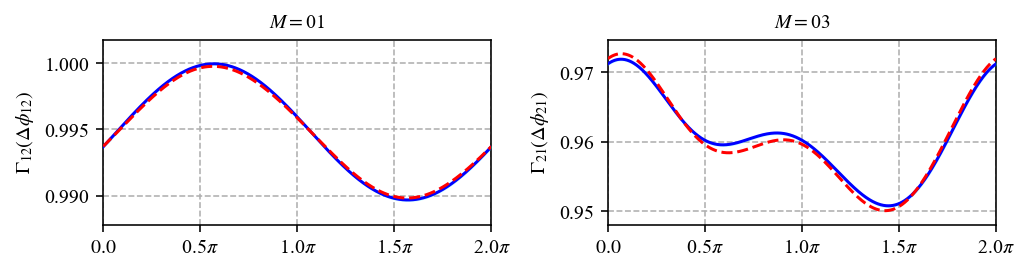

In [22]:
##### プロット用のデータ整理
estimate_omega1 = O1m; estimate_period1 = 2.0*np.pi/O1m
adjoint_omega1 = (2.0*np.pi)/period1; adjoint_period1 = period1
estimate_omega2 = O2m; estimate_period2 = 2.0*np.pi/O2m
adjoint_omega2 = (2.0*np.pi)/period2; adjoint_period2 = period2

xc1, yc1 = phi, G1m+O1m
xc2, yc2 = adjoint_phi1, adjoint_Gamma1+adjoint_omega1
yc_err= G1s; Gamma1_order = Gamma1_order

xd1, yd1 = phi, G2m+O2m
xd2, yd2 = adjoint_phi2, adjoint_Gamma2+adjoint_omega2
yd_err= G2s; Gamma2_order = Gamma2_order




fig = plt.figure(figsize=(4.0*2, 1.7))
fig.subplots_adjust(wspace=0.3)
#
cx = fig.add_subplot(121)
cx.plot(xc1, yc1, c="blue", linestyle="solid", zorder=4, label="MAP")
cx.plot(xc2, yc2, c="red", linestyle="--", zorder=5, label="adjoint")
cx.fill_between(xc1, yc1-yc_err, yc1+yc_err, color="cyan", alpha=0.2, zorder=3)

cx.set_title( r"$M=$" + "{:02d}".format(Gamma1_order), fontsize=10)
cx.set_xticklabels([r"$0.0$", r"0.5$\pi$", r"1.0$\pi$", r"1.5$\pi$", r"2.0$\pi$"])
cx.set_xlim(0.0, 2.0 * np.pi)
cx.set_ylim(yc2.min()-0.002, yc2.max()+0.002)
cx.set_xticks(np.linspace(0, 2.0 * np.pi, num=5))
cx.grid(linestyle="--")
cx.set_ylabel(r"$\Gamma_{12}(\Delta \phi_{12})$")
# 
dx = fig.add_subplot(122)
dx.plot(xd1, yd1, c="blue", linestyle="solid", zorder=4, label="MAP")
dx.plot(xd2, yd2, c="red", linestyle="--", zorder=5, label="adjoint")
dx.fill_between(xd1, yd1-yd_err, yd1+yd_err, color="cyan", alpha=0.2, zorder=3)

dx.set_title( r"$M=$" + "{:02d}".format(Gamma2_order), fontsize=10)
dx.set_xticklabels([r"$0.0$", r"0.5$\pi$", r"1.0$\pi$", r"1.5$\pi$", r"2.0$\pi$"])
dx.set_xlim(0.0, 2.0 * np.pi)
dx.set_xticks(np.linspace(0, 2.0 * np.pi, num=5))
dx.set_ylim(yd2.min()-0.002, yd2.max()+0.002)
dx.grid(linestyle="--")
dx.set_ylabel(r"$\Gamma_{21}(\Delta \phi_{21})$")

plt.savefig("vdP3.png", dpi=400)

# 位相差$2\pi$のデータごとに学習する場合

In [23]:
spaned_P_list = []

phase_diff = phase1 - phase2
for i in range(cycle):
    arg = (2.0*np.pi*i <= np.abs(phase_diff-phase_diff[0])) & (np.abs(phase_diff-phase_diff[0]) <= 2.0*np.pi*(i+1)) 
    spaned_tspan = tspan[arg]
    spaned_phase1 = phase1[arg]
    spaned_phase2 = phase2[arg]
    spaned_phase_diff = phase_diff[arg]
    spaned_u1 = u1[arg]
    spaned_v1 = v1[arg]
    spaned_u2 = u2[arg]
    spaned_v2 = v2[arg]
    spaned_P = P[arg, :] 
    spaned_P_list.append(spaned_P)
 



In [24]:
# 平均速度
v1_mean = (P[-1,0] - P[0,0]) / (tspan[-1] - tspan[0])
v2_mean = (P[-1,1] - P[0,0]) / (tspan[-1] - tspan[0])

# 準備
# receiver:1
Estimator1 = Estimator_module.Estimator(receiver=0, N=2,
                                        M_min=M_min, M_max=M_max,
                                        log10_lambda_0_min=log10_lambda_0_min, 
                                        log10_lambda_0_max=log10_lambda_0_max,  
                                        alpha_0=alpha_0, beta_0=beta_0)
# receiver:2
Estimator2 = Estimator_module.Estimator(receiver=1, N=2,
                                        M_min=M_min, M_max=M_max,
                                        log10_lambda_0_min=log10_lambda_0_min, 
                                        log10_lambda_0_max=log10_lambda_0_max,  
                                        alpha_0=alpha_0, beta_0=beta_0)
# set intial condition (initial condition of omega)
Estimator1.set_init_all(v1_mean)
Estimator2.set_init_all(v2_mean)


result_list = [] 
# 2piずつ学習させていく
for spaned_P in spaned_P_list:
    # update
    Estimator1.update_all(spaned_P, delta_t=dt)
    Estimator2.update_all(spaned_P, delta_t=dt)
    # model section
    result_model1, _ = Estimator1.model_selection()
    result_model2, _ = Estimator2.model_selection()
    ## データ整理
    G1m, G1s, phi  = result_model1.return_Gamma(sender=1)
    O1m, O1s = result_model1.return_omega()
    D1m, D1s = result_model1.return_D(delta_t=dt)
    Gamma1_order = result_model1.return_Gamma_order(sender=1)
    G2m, G2s, _   = result_model2.return_Gamma(sender=0)
    O2m, O2s = result_model2.return_omega()
    D2m, D2s = result_model2.return_D(delta_t=dt)
    Gamma2_order = result_model2.return_Gamma_order(sender=0)

    ## 推定結果のプロット用データをまとめる
    result_list.append([phi, G1m, G1s, O1m, O1s, D1m, D1s, Gamma1_order, 
                      G2m, G2s, O2m, O2s, D2m, D2s, Gamma2_order])

## アニメーションプロット

In [25]:
from IPython.display import HTML

fig = plt.figure(figsize=(4.0*2, 1.7))
fig.subplots_adjust(wspace=0.3)
cx = fig.add_subplot(121)
dx = fig.add_subplot(122)


def anime_update(frame):
    ##### 
    phi, G1m, G1s, O1m, O1s, D1m, D1s, Gamma1_order, \
    G2m, G2s, O2m, O2s, D2m, D2s, Gamma2_order = result_list[frame]
    
    ##### プロット用のデータ整理
    estimate_omega1 = O1m; estimate_period1 = 2.0*np.pi/O1m
    adjoint_omega1 = (2.0*np.pi)/period1; adjoint_period1 = period1
    estimate_omega2 = O2m; estimate_period2 = 2.0*np.pi/O2m
    adjoint_omega2 = (2.0*np.pi)/period2; adjoint_period2 = period2

    xc1, yc1 = phi, G1m+O1m
    xc2, yc2 = adjoint_phi1, adjoint_Gamma1+adjoint_omega1
    yc_err= G1s; Gamma1_order = Gamma1_order

    xd1, yd1 = phi, G2m+O2m
    xd2, yd2 = adjoint_phi2, adjoint_Gamma2+adjoint_omega2
    yd_err= G2s; Gamma2_order = Gamma2_order

    #####
    cx.cla()
    dx.cla()
    #####
    cx.set_title( r"$M=$" + "{:02d}".format(Gamma1_order) + "   " +\
                  "cycle={:02d}".format(frame+1), 
                  fontsize=10)
    dx.set_title( r"$M=$" + "{:02d}".format(Gamma2_order) + "   " +\
                  "cycle={:02d}".format(frame+1), 
                  fontsize=10)
    ######
    cx.plot(xc1, yc1, c="blue", linestyle="solid", zorder=4, label="MAP")
    cx.plot(xc2, yc2, c="red", linestyle="--", zorder=5, label="adjoint")
    cx.fill_between(xc1, yc1-yc_err, yc1+yc_err, color="cyan", alpha=0.2, zorder=3)
    cx.set_xticklabels([r"$0.0$", r"0.5$\pi$", r"1.0$\pi$", r"1.5$\pi$", r"2.0$\pi$"])
    cx.set_xlim(0.0, 2.0 * np.pi)
    cx.set_ylim(yc2.min()-0.002, yc2.max()+0.002)
    cx.set_xticks(np.linspace(0, 2.0 * np.pi, num=5))
    cx.grid(linestyle="--")
    cx.set_ylabel(r"$\Gamma_{12}(\Delta \phi_{12})$")
    #####
    dx.plot(xd1, yd1, c="blue", linestyle="solid", zorder=4, label="MAP")
    dx.plot(xd2, yd2, c="red", linestyle="--", zorder=5, label="adjoint")
    dx.fill_between(xd1, yd1-yd_err, yd1+yd_err, color="cyan", alpha=0.2, zorder=3)
    dx.set_xticklabels([r"$0.0$", r"0.5$\pi$", r"1.0$\pi$", r"1.5$\pi$", r"2.0$\pi$"])
    dx.set_xlim(0.0, 2.0 * np.pi)
    dx.set_xticks(np.linspace(0, 2.0 * np.pi, num=5))
    dx.set_ylim(yd2.min()-0.002, yd2.max()+0.002)
    dx.grid(linestyle="--")
    dx.set_ylabel(r"$\Gamma_{21}(\Delta \phi_{21})$")

                    
######
anim = FuncAnimation(fig, anime_update, frames=range(cycle), interval=250, repeat=True)
anim.save("vdP3.gif", dpi=300,  writer="imagemagick")
plt.close()

/usr/local/var/pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/var/pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/var/pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/var/pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/var/pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/var/pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: 